In [1]:
import pandas as pd
 
input_book = pd.ExcelFile('/home/brain/Downloads/心理検査DB_差分入り.xlsx')
input_exc = pd.ExcelFile('/home/brain/Downloads/Synapsology.運動習慣.xlsx')
result_lh_df = pd.read_table("/home/brain/Downloads/lh.thick.spc.csv", delim_whitespace=True)
result_rh_df = pd.read_table("/home/brain/Downloads/rh.thick.spc.csv", delim_whitespace=True)

#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names
exc_sheet_name = input_exc.sheet_names

#DataFrameとして一つ目のsheetを読込
exc_sheet_df = input_exc.parse(exc_sheet_name[0])
exc_sheet_df=exc_sheet_df.drop(exc_sheet_df.columns[[2,3,4]],axis=1)
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] == 0), exc_sheet_df.columns[2]] = 0
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] > 0) & (exc_sheet_df[exc_sheet_df.columns[2]] < 5), exc_sheet_df.columns[2]] = 1
exc_sheet_df.loc[(exc_sheet_df[exc_sheet_df.columns[2]] >= 5), exc_sheet_df.columns[2]] = 2

In [2]:
#DataFrameとして一つ目のsheetを読込
fu_sheet_df = input_book.parse(input_sheet_name[0])
fu_sheet_df=fu_sheet_df[fu_sheet_df[fu_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[0])

fu_sheet_df=fu_sheet_df.iloc[:,0:24]
fu_sheet_df=fu_sheet_df.drop(fu_sheet_df.columns[[21,22]],axis=1)
#読み込んだシートの先頭5行を表示
print(fu_sheet_df.shape)#head(5))

Sheet name: follow_without29
(51, 22)


In [3]:
#DataFrameとして3つ目のsheetを読込（グラフはsheetとしてカウントされない？）
bl_sheet_df = input_book.parse(input_sheet_name[1])
bl_sheet_df=bl_sheet_df[bl_sheet_df[bl_sheet_df.columns[0]].str.contains("",na=False)]

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[1])

bl_sheet_df=bl_sheet_df.drop(bl_sheet_df.columns[[21,23,27,28]],axis=1)
#読み込んだシートの先頭5行を表示
print(bl_sheet_df.shape)#head(5))

Sheet name: baseline_without29
(51, 29)


In [4]:
bl_fu_sheet_df=pd.merge(bl_sheet_df, fu_sheet_df, left_on=bl_sheet_df.columns[0], right_on=fu_sheet_df.columns[0], how="inner", suffixes = ["_bl", "_fu"])
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace(" ","_")
bl_fu_sheet_df.columns=bl_fu_sheet_df.columns.str.replace("\n","_")
bl_fu_sheet_df=pd.merge(exc_sheet_df, bl_fu_sheet_df, left_on=exc_sheet_df.columns[0], right_on=bl_fu_sheet_df.columns[0], how="inner", suffixes = ["_exc", ""])
print(bl_fu_sheet_df.shape)#head(5))

(51, 52)


In [5]:
#print(result_lh_df.head(5))
#print(result_rh_df.head(5))
bl_fu_bilateral_df=pd.merge(result_lh_df, result_rh_df, left_on=result_lh_df.columns[0], right_on=result_rh_df.columns[0], how="inner", suffixes = ["_lh", "_rh"])
print(bl_fu_bilateral_df.shape)#head(5))

(50, 75)


In [6]:
df_result=pd.merge(bl_fu_sheet_df, bl_fu_bilateral_df, left_on=bl_fu_sheet_df.columns[0], right_on=bl_fu_bilateral_df.columns[0], how="inner").sort_values(by=bl_fu_sheet_df.columns[0])
print(df_result.shape)
#print(df_result)
print(type(df_result))

(50, 127)
<class 'pandas.core.frame.DataFrame'>


In [7]:
df_result=df_result.T.drop_duplicates().T # 重複列削除
df_result=df_result.set_index("研究ID")
print(df_result.shape)
print(type(df_result))
df_result.to_csv('/home/brain/Downloads/spc_df_result.csv')
df_result = pd.read_csv('/home/brain/Downloads/spc_df_result.csv')
df_result=df_result.set_index("研究ID")
df_result=df_result.drop(columns=["検査日_bl", "検査日_fu", "年齢_fu"])
print(df_result.shape)
print(type(df_result))
#
"""print(df_result.index)
print(df_result.columns)
print(df_result.columns.get_loc('lh_bankssts_thickness'))
print(df_result.columns.get_loc('rh_MeanThickness_thickness'))
print(df_result[['年齢_bl', '性別_1：男性_２：女性_bl','運動習慣','運動習慣_あり_運動時間']].head(5))"""

(50, 120)
<class 'pandas.core.frame.DataFrame'>
(50, 117)
<class 'pandas.core.frame.DataFrame'>


"print(df_result.index)\nprint(df_result.columns)\nprint(df_result.columns.get_loc('lh_bankssts_thickness'))\nprint(df_result.columns.get_loc('rh_MeanThickness_thickness'))\nprint(df_result[['年齢_bl', '性別_1：男性_２：女性_bl','運動習慣','運動習慣_あり_運動時間']].head(5))"

                                     spc      pval
15              lh_paracentral_thickness  0.016735
10     lh_lateralorbitofrontal_thickness  0.104010
21       lh_posteriorcingulate_thickness  0.193683
37  rh_caudalanteriorcingulate_thickness  0.195481
38      rh_caudalmiddlefrontal_thickness  0.204341
..                                   ...       ...
12      lh_medialorbitofrontal_thickness  0.905841
5                  lh_fusiform_thickness  0.906258
41                 rh_fusiform_thickness  0.912247
70            rh_MeanThickness_thickness  0.919063
25     lh_rostralmiddlefrontal_thickness  0.979411

[71 rows x 2 columns]


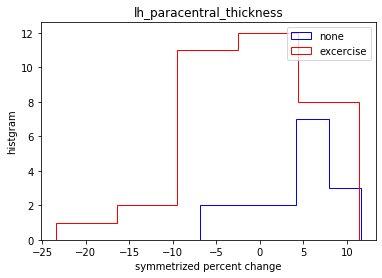

In [8]:
from scipy import stats

ttest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ttest_A=df_result.loc[(df_result['運動習慣'] == 0),df_result.columns[ii]]
    ttest_B=df_result.loc[(df_result['運動習慣'] == 1),df_result.columns[ii]]
#    print(ttest_A.shape, ttest_A.head(5))
#    print(ttest_B.shape, ttest_B.head(5))
    ttest_result=stats.ttest_ind(ttest_A,ttest_B)
    #ttest_result=stats.ttest_rel(ttest_A,ttest_B)
    ttest_result_df=ttest_result_df.append(pd.DataFrame([[df_result.columns[ii],ttest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ttest_result_df.sort_values('pval'))
#
import matplotlib.pyplot as plt
ttest_A=df_result.loc[(df_result['運動習慣'] == 0),'lh_paracentral_thickness']
ttest_B=df_result.loc[(df_result['運動習慣'] == 1),'lh_paracentral_thickness']
plt.hist(ttest_A, bins=5, histtype="step", color="b", label="none")
plt.hist(ttest_B, bins=5, histtype="step", color="r", label="excercise")
plt.title("lh_paracentral_thickness")
plt.xlabel("symmetrized percent change")
plt.ylabel("histgram")
plt.legend()
plt.savefig('figure.png')

In [9]:
#'年齢_bl','運動習慣_あり_運動時間'
from statsmodels.formula.api import ols

df_result['n運動習慣'] = 0
df_result.loc[(df_result['運動習慣'] == 0),'n運動習慣'] = 1

ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ttest_A=df_result.loc[(df_result['運動習慣'] == 0),df_result.columns[ii]]
    ttest_B=df_result.loc[(df_result['運動習慣'] == 1),df_result.columns[ii]]
    ftest_A=df_result.loc[:,['年齢_bl','運動習慣','n運動習慣',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ 運動習慣 + n運動習慣 + 年齢_bl', ftest_A).fit()
    #print(model.summary())
    ftest_result=model.f_test([0, 1, -1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii],ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                     spc                 pval
15              lh_paracentral_thickness  0.06521633186678681
10     lh_lateralorbitofrontal_thickness  0.06855451178118446
13           lh_middletemporal_thickness  0.12322331736738659
37  rh_caudalanteriorcingulate_thickness   0.1504070320466169
19            lh_pericalcarine_thickness  0.16370644546916785
..                                   ...                  ...
39                   rh_cuneus_thickness    0.916392092924125
28         lh_superiortemporal_thickness   0.9252731407596322
67             rh_temporalpole_thickness   0.9324047385057815
61     rh_rostralmiddlefrontal_thickness    0.933111995020979
32       lh_transversetemporal_thickness   0.9539083771565285

[71 rows x 2 columns]


                                  spc      pval
43      rh_inferiortemporal_thickness  0.024123
15           lh_paracentral_thickness  0.043379
68    rh_transversetemporal_thickness  0.045278
59             rh_precuneus_thickness  0.081817
63      rh_superiorparietal_thickness  0.085495
..                                ...       ...
48   rh_medialorbitofrontal_thickness  0.906486
34         lh_MeanThickness_thickness  0.926320
25  lh_rostralmiddlefrontal_thickness  0.953235
6       lh_inferiorparietal_thickness  0.963000
41              rh_fusiform_thickness  0.988833

[71 rows x 2 columns]


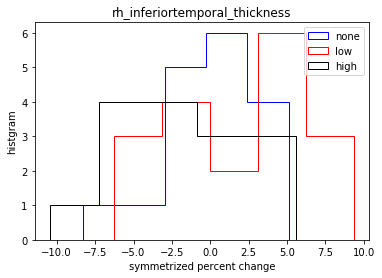

In [10]:
from scipy import stats

ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),df_result.columns[ii]]
    ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),df_result.columns[ii]]
    ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),df_result.columns[ii]]
#    print(ftest_A.shape, ftest_A.head(5))
#    print(ftest_B.shape, ftest_B.head(5))
    ftest_result=stats.f_oneway(ftest_A,ftest_B,ftest_C)
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii],ftest_result.pvalue]], columns=ftest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))
#
import matplotlib.pyplot as plt
ftest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),'rh_inferiortemporal_thickness']
ftest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),'rh_inferiortemporal_thickness']
ftest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),'rh_inferiortemporal_thickness']
plt.hist(ftest_A, bins=5, histtype="step", color="b", label="none")
plt.hist(ftest_B, bins=5, histtype="step", color="r", label="low")
plt.hist(ftest_C, bins=5, histtype="step", color="k", label="high")
plt.title("rh_inferiortemporal_thickness")
plt.xlabel("symmetrized percent change")
plt.ylabel("histgram")
plt.legend()
plt.savefig('f_figure.png')

In [11]:
#'年齢_bl','運動習慣_あり_運動時間'
from statsmodels.formula.api import ols

df_result['n運動習慣'] = 0
df_result['l運動習慣'] = 0
df_result['h運動習慣'] = 0
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),'n運動習慣'] = 1
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),'l運動習慣'] = 1
df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),'h運動習慣'] = 1
#print(df_result.head())
ftest_result_df = pd.DataFrame(index=[], columns=['spc', 'pval'])
for ii in range(df_result.columns.get_loc('lh_bankssts_thickness'),df_result.columns.get_loc('rh_MeanThickness_thickness')+1):
    ttest_A=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 0),df_result.columns[ii]]
    ttest_B=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 1),df_result.columns[ii]]
    ttest_C=df_result.loc[(df_result['運動習慣_あり_運動時間'] == 2),df_result.columns[ii]]
    ftest_A=df_result.loc[:,['年齢_bl','n運動習慣','l運動習慣','h運動習慣',df_result.columns[ii]]]
    #print(ftest_A.head())
    model=ols(df_result.columns[ii]+' ~ n運動習慣 + l運動習慣 + h運動習慣 + 年齢_bl', ftest_A).fit()
    #print(model.summary())
    ftest_result=model.f_test([0, 1, -1, 0, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_nl",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, 1, 0, -1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_nh",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
    ftest_result=model.f_test([0, 0, 1, -1, 0])
    ftest_result_df=ftest_result_df.append(pd.DataFrame([[df_result.columns[ii]+"_lh",ftest_result.pvalue]], columns=ttest_result_df.columns),ignore_index=True)
print(ftest_result_df.sort_values('pval'))

                                    spc                  pval
131    rh_inferiortemporal_thickness_lh  0.006607215638247857
204  rh_transversetemporal_thickness_nl  0.026263655242645713
203        rh_temporalpole_thickness_lh   0.04097787614925351
170         rh_postcentral_thickness_lh  0.057643605759582765
46          lh_paracentral_thickness_nh   0.08008254404844509
..                                  ...                   ...
136    rh_lateraloccipital_thickness_nh    0.9778732069661477
186     rh_superiorfrontal_thickness_nl    0.9794058363756997
189    rh_superiorparietal_thickness_nl    0.9905612086526886
143             rh_lingual_thickness_lh    0.9933899918940747
22     lh_inferiortemporal_thickness_nh    0.9936146113616432

[213 rows x 2 columns]


In [12]:
#print(df_result)
corr_matp = df_result.corr(method='pearson')
#print(corr_matp)
corr_matp=corr_matp.dropna(how = 'all')
corr_matp=corr_matp.dropna(axis = 'columns')
corr_matp.to_csv('/home/brain/Downloads/spc_corr_matp.csv')

/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36939 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24931 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/brain/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: 

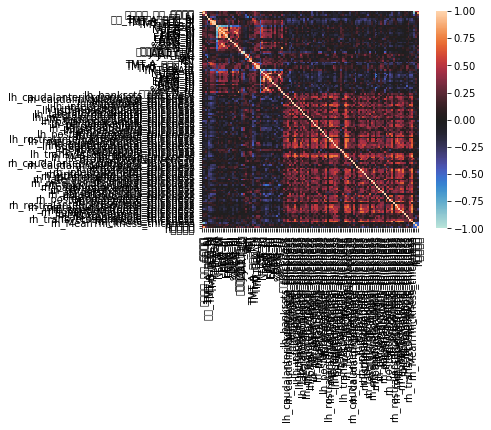

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matp,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_matp.columns.values,
            yticklabels=corr_matp.columns.values
           )
plt.show()
#fig = plt.figure(figsize=(10,10),dpi=200)
#fig.show()

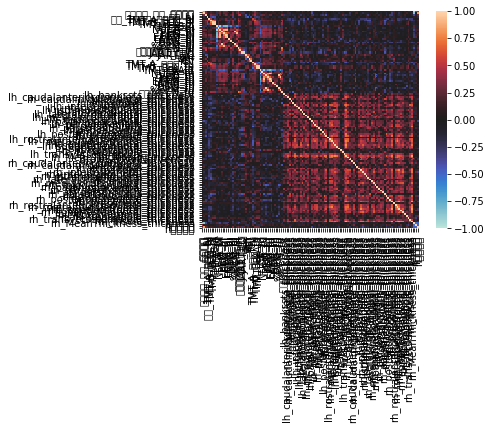

In [14]:
corr_mats = df_result.corr(method='spearman')
corr_mats=corr_mats.dropna(how = 'all')
corr_mats=corr_mats.dropna(axis = 'columns')
corr_mats.to_csv('/home/brain/Downloads/spc_corr_mats.csv')
sns.heatmap(corr_mats,square=True,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=False, # True:格子の中に値を表示
#            fmt='.1f',
            xticklabels=corr_mats.columns.values,
            yticklabels=corr_mats.columns.values
           )
plt.show()

In [15]:
print(corr_matp)

                                運動習慣  運動習慣_あり_運動時間     年齢_bl  性別_1：男性_２：女性_bl  \
運動習慣                        1.000000      0.824224  0.305159        -0.065492   
運動習慣_あり_運動時間                0.824224      1.000000  0.398168        -0.158406   
年齢_bl                       0.305159      0.398168  1.000000        -0.059937   
性別_1：男性_２：女性_bl            -0.065492     -0.158406 -0.059937         1.000000   
TMT-A_（秒）_bl                0.087564      0.109555  0.025382        -0.016302   
...                              ...           ...       ...              ...   
rh_insula_thickness         0.099393      0.005872 -0.027630         0.041934   
rh_MeanThickness_thickness -0.014743     -0.150742 -0.146043         0.010606   
n運動習慣                      -0.955769     -0.862367 -0.414447         0.082918   
l運動習慣                       0.514496      0.037547  0.155247         0.100017   
h運動習慣                       0.449089      0.852116  0.265809        -0.190476   

                           

In [16]:
print(corr_mats)

                                運動習慣  運動習慣_あり_運動時間     年齢_bl  性別_1：男性_２：女性_bl  \
運動習慣                        1.000000      0.832633  0.301563        -0.065492   
運動習慣_あり_運動時間                0.832633      1.000000  0.371247        -0.156511   
年齢_bl                       0.301563      0.371247  1.000000        -0.049389   
性別_1：男性_２：女性_bl            -0.065492     -0.156511 -0.049389         1.000000   
TMT-A_（秒）_bl                0.059441      0.072868  0.071276        -0.041598   
...                              ...           ...       ...              ...   
rh_insula_thickness         0.133697      0.051638 -0.043335         0.003780   
rh_MeanThickness_thickness -0.019313     -0.144088 -0.128009        -0.011342   
n運動習慣                      -0.955769     -0.871165 -0.368993         0.082918   
l運動習慣                       0.514496      0.055171  0.113164         0.100017   
h運動習慣                       0.449089      0.842750  0.262901        -0.190476   

                           